<a href="https://colab.research.google.com/github/sundar-nallalagappan/Coursera_Timeseries/blob/main/Time_series_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
print("sairam")

sairam


In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from keras.layers import Dense, Flatten, Conv1D, LSTM, SimpleRNN, Lambda, Conv1D
from keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np
import csv

from dataclasses import dataclass

2.12.0


In [4]:
def parse_input_file(file_path):

  time   = []
  series = []

  with open(file_path, "r") as file:
    csv_data = csv.reader(file, delimiter=",")
    next(csv_data)
    for i, rec in enumerate(csv_data):
      time.append(i)
      series.append(float(rec[1]))

  time = np.array(time)
  series = np.array(series)

  print("shape of time", time.shape)
  print("shape of series", series.shape)

  return time, series


In [5]:
def plot_series(x, y, start = 0, end=None, format='-'):
  #plt.figure(figsize=(10, 8))
  plt.plot(x[start:end], y[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("series")
  #plt.ylim(0,50)
  #plt.grid(True)
  plt.show()

In [10]:
@dataclass
class static:
  WINDOW_SIZE         = 30
  BATCH_SIZE          = 32
  SHUFFLE_BUFFER_SIZE = 1000
  TIME_SPLIT          = 2500
  LEARNING_RATE       = 1e-3
  TIME, SERIES        = parse_input_file("/content/daily-min-temperatures.csv")


shape of time (3650,)
shape of series (3650,)


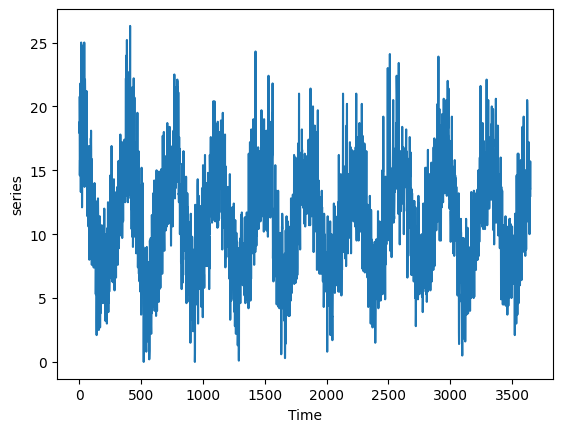

In [11]:
plot_series(static.TIME, static.SERIES)

In [12]:
def train_test_split(time, series, time_split=static.TIME_SPLIT):
  time_train   = time[:time_split]
  series_train = series[:time_split]

  time_test   = time[time_split:]
  series_test = series[time_split:]

  print(f"train shape --> {time_train.shape} {series_train.shape}")
  print(f"test shape --> {time_test.shape} {series_test.shape}")

  return time_train, series_train, time_test, series_test

In [13]:
time_train, series_train, time_test, series_test = train_test_split(static.TIME, static.SERIES)

train shape --> (2500,) (2500,)
test shape --> (1150,) (1150,)


In [14]:
def windowed_data(series, window_size, batch_size, shuffle_buffer_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

def test_windowed_data(series, window_size, batch_size, shuffle_buffer_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  return ds



In [15]:
train_ds = windowed_data(series_train, static.WINDOW_SIZE, static.BATCH_SIZE, static.SHUFFLE_BUFFER_SIZE)

for x, y in train_ds:
  print(x.numpy())
  print(y.numpy())
  break

[[17.8 15.  13.6 13.4 10.5 14.2 11.5 13.  15.  14.7 12.6 12.5 13.5 14.8
  17.2  9.7 12.1 12.8 11.2 16.4 15.6 13.3 11.  11.1 15.  12.8 15.  14.2
  14.  15.5]
 [ 7.8  9.1 13.  16.5 12.9  6.9  6.9  8.7 10.  10.8  7.5  6.3 11.9 13.8
  11.8 11.  10.1  8.5  5.5  7.6  8.7 10.8 11.2  9.1  3.7  4.6  6.6 13.2
  15.2  7.6]
 [22.  22.1 21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5
  21.2 17.8 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8
  11.3 10.6]
 [10.7 10.  13.9 13.4 12.5 12.8  7.8 11.1 10.7  7.1  6.7  5.7  9.1 15.2
  15.5 11.1 11.7 11.5  9.8  6.2  6.7  7.5  8.8  8.  10.4 14.5 16.5 14.1
  10.5 12.6]
 [ 4.9  7.4  8.3  7.5  6.2  7.8 13.2 11.9  6.5  8.3 12.1  9.3  7.5  9.3
  11.  10.8  5.3  7.6  5.6  7.2  9.6  7.   8.3  7.8  4.7  6.8  7.2  8.3
   9.5  4.7]
 [ 7.4  8.3  7.5  6.2  7.8 13.2 11.9  6.5  8.3 12.1  9.3  7.5  9.3 11.
  10.8  5.3  7.6  5.6  7.2  9.6  7.   8.3  7.8  4.7  6.8  7.2  8.3  9.5
   4.7  3. ]
 [10.9 14.1 10.7 16.9 10.5  6.5 11.   6.3 10.5  7.2  7.6 10

# Simple RNN

In [30]:
model = Sequential([
    SimpleRNN(40, input_shape=[static.WINDOW_SIZE, 1]),
    Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 40)                1680      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
_________________________________________________________________


In [31]:
SGD_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

In [32]:
epochs = 10
history = model.fit(train_ds, verbose=2, epochs=epochs)

Epoch 1/10
78/78 - 2s - loss: 4.2905 - mae: 4.7623 - 2s/epoch - 28ms/step
Epoch 2/10
78/78 - 1s - loss: 1.7691 - mae: 2.2155 - 772ms/epoch - 10ms/step
Epoch 3/10
78/78 - 1s - loss: 1.6361 - mae: 2.0782 - 809ms/epoch - 10ms/step
Epoch 4/10
78/78 - 1s - loss: 1.6167 - mae: 2.0622 - 932ms/epoch - 12ms/step
Epoch 5/10
78/78 - 1s - loss: 1.5908 - mae: 2.0348 - 1s/epoch - 17ms/step
Epoch 6/10
78/78 - 1s - loss: 1.5595 - mae: 2.0025 - 767ms/epoch - 10ms/step
Epoch 7/10
78/78 - 1s - loss: 1.5803 - mae: 2.0222 - 787ms/epoch - 10ms/step
Epoch 8/10
78/78 - 1s - loss: 1.5718 - mae: 2.0174 - 804ms/epoch - 10ms/step
Epoch 9/10
78/78 - 1s - loss: 1.5419 - mae: 1.9845 - 791ms/epoch - 10ms/step
Epoch 10/10
78/78 - 1s - loss: 1.5478 - mae: 1.9929 - 763ms/epoch - 10ms/step


In [34]:
history.history.keys()

dict_keys(['loss', 'mae'])

In [16]:
def plot_accuracy(history, epochs=10):
  loss = history.history['loss']
  plt.plot(range(epochs), loss)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
plot_accuracy(history, epochs)

In [18]:
def evaluate_model(actual, pred):
  mae = tf.keras.metrics.mean_absolute_error(actual, pred).numpy()
  mse = tf.keras.metrics.mean_squared_error(actual, pred).numpy()

  print(f"MAE: {mae}")
  print(f"MSE: {mse}")

  return mae, mse

In [ ]:
test_ds = test_windowed_data(static.SERIES, static.WINDOW_SIZE, static.BATCH_SIZE, static.SHUFFLE_BUFFER_SIZE)

#for x in test_ds:
#  print(x.numpy())
#  break

forecast = model.predict(test_ds)

In [51]:
rnn_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE : -1]
print(rnn_forecast.shape)
rnn_forecast

(1150, 1)


array([[12.079276],
       [11.0706  ],
       [12.129871],
       ...,
       [13.544274],
       [13.52344 ],
       [14.781718]], dtype=float32)

In [54]:
rnn_forecast = rnn_forecast.squeeze()

In [55]:
rnn_forecast

array([12.079276, 11.0706  , 12.129871, ..., 13.544274, 13.52344 ,
       14.781718], dtype=float32)

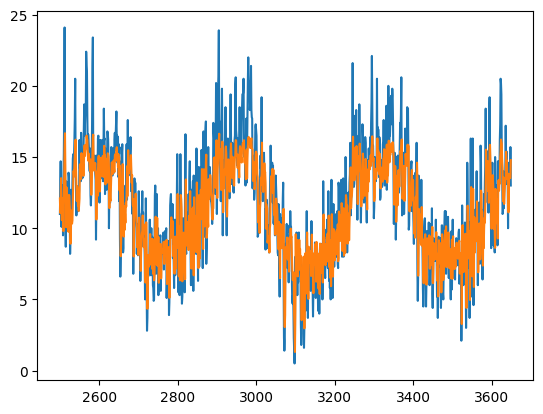

In [57]:
plt.plot(time_test, series_test)
plt.plot(time_test, rnn_forecast)

In [58]:
evaluate_model(series_test,rnn_forecast)

MAE: 1.8652411699295044
MSE: 5.710159778594971


(1.8652412, 5.71016)

# Simple Linear Model

In [65]:
lin_model = Sequential(
    Dense(1, input_shape=[static.WINDOW_SIZE])
)

lin_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [66]:
SGD_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
lin_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

In [67]:
lin_model.fit(train_ds, epochs=10)

Epoch 1/10
78/78 [==============================] - 2s 9ms/step - loss: 2.9246 - mae: 3.3943
Epoch 2/10
78/78 [==============================] - 1s 8ms/step - loss: 2.0477 - mae: 2.5060
Epoch 3/10
78/78 [==============================] - 1s 5ms/step - loss: 1.6561 - mae: 2.1045
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 2.1985 - mae: 2.6579
Epoch 5/10
78/78 [==============================] - 0s 5ms/step - loss: 1.7111 - mae: 2.1566
Epoch 6/10
78/78 [==============================] - 0s 4ms/step - loss: 1.7404 - mae: 2.1900
Epoch 7/10
78/78 [==============================] - 0s 4ms/step - loss: 1.7451 - mae: 2.1959
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 1.8772 - mae: 2.3321
Epoch 9/10
78/78 [==============================] - 0s 4ms/step - loss: 1.7356 - mae: 2.1868
Epoch 10/10
78/78 [==============================] - 0s 4ms/step - loss: 1.9059 - mae: 2.3573


114/114 [==============================] - 1s 11ms/step
(1150, 1)
[ 9.96492    9.566286  10.5829315 ... 11.529017  11.433076  12.839076 ]
MAE: 2.449167490005493
MSE: 9.070184707641602


(2.4491675, 9.070185)

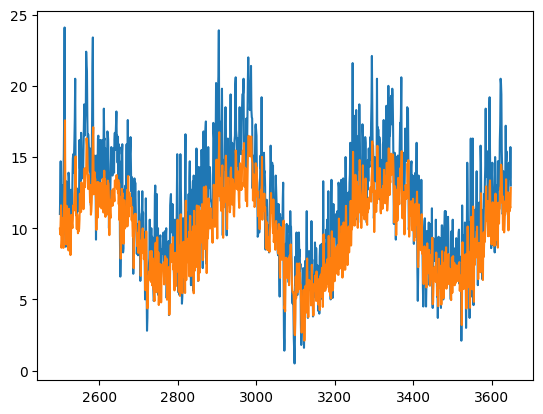

In [70]:
forecast = lin_model.predict(test_ds)
lin_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE : -1]
print(lin_forecast.shape)
lin_forecast = lin_forecast.squeeze()
print(lin_forecast)

plt.plot(time_test, series_test)
plt.plot(time_test, lin_forecast)

evaluate_model(series_test,lin_forecast)

# DNN

In [73]:
dnn_model = Sequential([
    Dense(10, input_shape=[static.WINDOW_SIZE], activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                310       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


In [74]:
SGD_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
dnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

In [75]:
dnn_model.fit(train_ds, epochs=10)

Epoch 1/10
78/78 [==============================] - 1s 4ms/step - loss: 2.6068 - mae: 3.0687
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 1.7690 - mae: 2.2200
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 1.7177 - mae: 2.1687
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 1.7392 - mae: 2.1930
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 1.6731 - mae: 2.1234
Epoch 6/10
78/78 [==============================] - 1s 11ms/step - loss: 1.5996 - mae: 2.0475
Epoch 7/10
78/78 [==============================] - 0s 5ms/step - loss: 1.6721 - mae: 2.1237
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 1.5633 - mae: 2.0094
Epoch 9/10
78/78 [==============================] - 0s 4ms/step - loss: 1.5708 - mae: 2.0202
Epoch 10/10
78/78 [==============================] - 0s 4ms/step - loss: 1.5859 - mae: 2.0340


114/114 [==============================] - 1s 6ms/step
(1150, 1)
[12.374946 11.772047 12.656096 ... 13.516255 13.569194 14.984866]
MAE: 1.8020628690719604
MSE: 5.304691314697266


(1.8020629, 5.3046913)

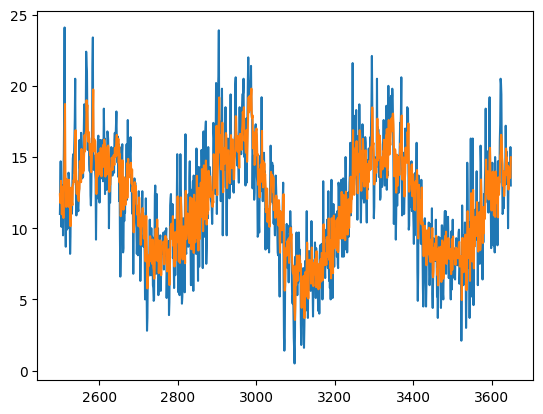

In [76]:
forecast = dnn_model.predict(test_ds)
dnn_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE : -1]
print(dnn_forecast.shape)
dnn_forecast = dnn_forecast.squeeze()
print(dnn_forecast)

plt.plot(time_test, series_test)
plt.plot(time_test, dnn_forecast)

evaluate_model(series_test,dnn_forecast)

# Simple RNN + Lambda

In [80]:
for x, y in train_ds:
  print(x.numpy())
  print(y.numpy())
  break

[[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5
  25.  20.7 20.6 24.8 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2
  15.5 15.1]
 [14.5 11.7  6.7  4.6  4.9  7.4  8.3  7.5  6.2  7.8 13.2 11.9  6.5  8.3
  12.1  9.3  7.5  9.3 11.  10.8  5.3  7.6  5.6  7.2  9.6  7.   8.3  7.8
   4.7  6.8]
 [ 5.4  7.5  3.9  2.5  5.3  6.6  0.   0.7  7.6 12.3  9.2  9.6  9.5 10.
   7.7  8.   8.3  8.3  4.5  6.5  9.4  9.4 10.5 10.7  9.9  7.6  5.8  8.5
  13.8 14.3]
 [11.  10.8  5.3  7.6  5.6  7.2  9.6  7.   8.3  7.8  4.7  6.8  7.2  8.3
   9.5  4.7  3.   1.5  2.5  6.2 11.6  6.6  6.6  8.   7.9  3.3  3.9  6.
   4.   5.5]
 [13.  11.2 13.5 12.9  6.8 10.  14.5 11.7  6.7  4.6  4.9  7.4  8.3  7.5
   6.2  7.8 13.2 11.9  6.5  8.3 12.1  9.3  7.5  9.3 11.  10.8  5.3  7.6
   5.6  7.2]
 [11.7  7.8 12.3 10.1 11.5  7.3 10.9 14.1 10.7 16.9 10.5  6.5 11.   6.3
  10.5  7.2  7.6 10.7  7.8  9.6 11.4 12.4  8.9 13.2  8.6  6.2 11.4 13.2
  14.3  7.3]
 [ 7.6 12.3  9.2  9.6  9.5 10.   7.7  8.   8.3  8.3  4.5  6.

In [100]:
rnn_model = Sequential([
    SimpleRNN(60, return_sequences=True, input_shape=[static.WINDOW_SIZE,1]),
    SimpleRNN(60),
    Dense(1),
    Lambda(lambda x: x * 10)
])

rnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_14 (SimpleRNN)   (None, 30, 60)            3720      
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 60)                7260      
                                                                 
 dense_16 (Dense)            (None, 1)                 61        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 11,041
Trainable params: 11,041
Non-trainable params: 0
_________________________________________________________________


In [94]:
SGD_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
rnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

In [95]:
rnn_history = rnn_model.fit(train_ds, epochs=10)

Epoch 1/10
78/78 [==============================] - 4s 23ms/step - loss: 2.5342 - mae: 2.9975
Epoch 2/10
78/78 [==============================] - 3s 30ms/step - loss: 1.8804 - mae: 2.3294
Epoch 3/10
78/78 [==============================] - 2s 18ms/step - loss: 1.8360 - mae: 2.2878
Epoch 4/10
78/78 [==============================] - 2s 18ms/step - loss: 1.9393 - mae: 2.3967
Epoch 5/10
78/78 [==============================] - 2s 19ms/step - loss: 1.7492 - mae: 2.1989
Epoch 6/10
78/78 [==============================] - 4s 45ms/step - loss: 2.0069 - mae: 2.4651
Epoch 7/10
78/78 [==============================] - 2s 18ms/step - loss: 1.7576 - mae: 2.2041
Epoch 8/10
78/78 [==============================] - 2s 18ms/step - loss: 1.6532 - mae: 2.1017
Epoch 9/10
78/78 [==============================] - 2s 18ms/step - loss: 1.7631 - mae: 2.2122
Epoch 10/10
78/78 [==============================] - 2s 18ms/step - loss: 1.7679 - mae: 2.2179


114/114 [==============================] - 1s 9ms/step
shape of forecast before (1150, 1)
shape of forecast after (1150,)


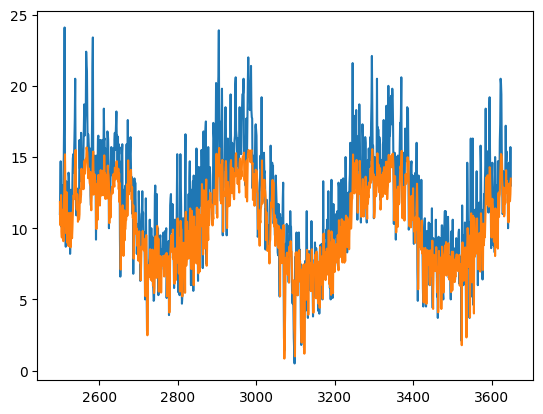

MAE: 2.1721384525299072
MSE: 7.397114276885986


(2.1721385, 7.3971143)

In [97]:
test_ds = test_windowed_data(static.SERIES, static.WINDOW_SIZE, static.BATCH_SIZE, static.SHUFFLE_BUFFER_SIZE)
forecast = rnn_model.predict(test_ds)
rnn_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE: -1]
print(f"shape of forecast before {rnn_forecast.shape}")
rnn_forecast = rnn_forecast.squeeze()
print(f"shape of forecast after {rnn_forecast.shape}")

plt.plot(time_test, series_test)
plt.plot(time_test, rnn_forecast)
plt.show()

evaluate_model(series_test, rnn_forecast)

In [108]:
rnn_model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    SimpleRNN(60, return_sequences=True),
    SimpleRNN(60),
    Dense(1),
    #Lambda(lambda x: x * 10)
])

#rnn_model.summary()

In [109]:
SGD_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
rnn_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

In [110]:
rnn_history = rnn_model.fit(train_ds, epochs=10)

Epoch 1/10
78/78 [==============================] - 7s 43ms/step - loss: 3.4959 - mae: 3.9613
Epoch 2/10
78/78 [==============================] - 3s 35ms/step - loss: 1.7653 - mae: 2.2161
Epoch 3/10
78/78 [==============================] - 3s 36ms/step - loss: 1.5879 - mae: 2.0314
Epoch 4/10
78/78 [==============================] - 2s 20ms/step - loss: 1.5418 - mae: 1.9859
Epoch 5/10
78/78 [==============================] - 2s 24ms/step - loss: 1.5364 - mae: 1.9807
Epoch 6/10
78/78 [==============================] - 2s 19ms/step - loss: 1.5255 - mae: 1.9658
Epoch 7/10
78/78 [==============================] - 2s 19ms/step - loss: 1.5353 - mae: 1.9759
Epoch 8/10
78/78 [==============================] - 2s 18ms/step - loss: 1.5237 - mae: 1.9650
Epoch 9/10
78/78 [==============================] - 2s 18ms/step - loss: 1.5144 - mae: 1.9522
Epoch 10/10
78/78 [==============================] - 3s 33ms/step - loss: 1.5106 - mae: 1.9476


114/114 [==============================] - 1s 9ms/step
shape of forecast before (1150, 1)
shape of forecast after (1150,)


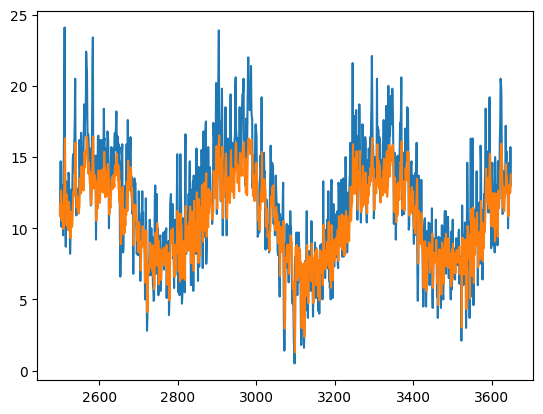

MAE: 1.9978399276733398
MSE: 6.383152008056641


(1.9978399, 6.383152)

In [111]:
test_ds = test_windowed_data(static.SERIES, static.WINDOW_SIZE, static.BATCH_SIZE, static.SHUFFLE_BUFFER_SIZE)
forecast = rnn_model.predict(test_ds)
rnn_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE: -1]
print(f"shape of forecast before {rnn_forecast.shape}")
rnn_forecast = rnn_forecast.squeeze()
print(f"shape of forecast after {rnn_forecast.shape}")

plt.plot(time_test, series_test)
plt.plot(time_test, rnn_forecast)
plt.show()

evaluate_model(series_test, rnn_forecast)

# LSTM

In [14]:
lstm_model = Sequential([
    #Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    LSTM(60, return_sequences=True, input_shape=[static.WINDOW_SIZE,1]),
    LSTM(60),
    Dense(1),
    #Lambda(lambda x: x * 10)
])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 60)            14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________


In [17]:
lr_sch = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-6 * 10 ** (epoch/20))

SGD_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

lstm_history = lstm_model.fit(train_ds, epochs=100, callbacks=[lr_sch])

Epoch 1/100
78/78 [==============================] - 8s 38ms/step - loss: 9.5729 - mae: 10.0715 - lr: 1.0000e-06
Epoch 2/100
78/78 [==============================] - 4s 48ms/step - loss: 9.5515 - mae: 10.0501 - lr: 1.1220e-06
Epoch 3/100
78/78 [==============================] - 6s 73ms/step - loss: 9.5273 - mae: 10.0259 - lr: 1.2589e-06
Epoch 4/100
78/78 [==============================] - 3s 37ms/step - loss: 9.5004 - mae: 9.9989 - lr: 1.4125e-06
Epoch 5/100
78/78 [==============================] - 4s 54ms/step - loss: 9.4703 - mae: 9.9688 - lr: 1.5849e-06
Epoch 6/100
78/78 [==============================] - 3s 37ms/step - loss: 9.4369 - mae: 9.9353 - lr: 1.7783e-06
Epoch 7/100
78/78 [==============================] - 3s 38ms/step - loss: 9.3997 - mae: 9.8981 - lr: 1.9953e-06
Epoch 8/100
78/78 [==============================] - 4s 53ms/step - loss: 9.3583 - mae: 9.8566 - lr: 2.2387e-06
Epoch 9/100
78/78 [==============================] - 3s 38ms/step - loss: 9.3122 - mae: 9.8106 - lr: 

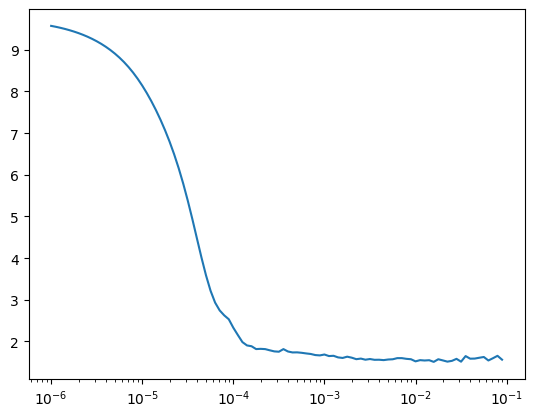

In [18]:
plt.semilogx(lstm_history.history['lr'], lstm_history.history['loss'])

In [19]:
SGD_opt = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
lstm_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
              optimizer = SGD_opt)

In [20]:
lstm_history = lstm_model.fit(train_ds, epochs=10)

Epoch 1/10
78/78 [==============================] - 8s 37ms/step - loss: 1.4811 - mae: 1.9203
Epoch 2/10
78/78 [==============================] - 3s 38ms/step - loss: 1.4740 - mae: 1.9147
Epoch 3/10
78/78 [==============================] - 4s 46ms/step - loss: 1.4832 - mae: 1.9218
Epoch 4/10
78/78 [==============================] - 3s 37ms/step - loss: 1.4696 - mae: 1.9116
Epoch 5/10
78/78 [==============================] - 3s 36ms/step - loss: 1.4621 - mae: 1.9003
Epoch 6/10
78/78 [==============================] - 3s 38ms/step - loss: 1.4660 - mae: 1.9027
Epoch 7/10
78/78 [==============================] - 3s 37ms/step - loss: 1.4878 - mae: 1.9302
Epoch 8/10
78/78 [==============================] - 4s 52ms/step - loss: 1.4564 - mae: 1.8924
Epoch 9/10
78/78 [==============================] - 3s 39ms/step - loss: 1.4607 - mae: 1.9008
Epoch 10/10
78/78 [==============================] - 3s 36ms/step - loss: 1.4652 - mae: 1.9041


114/114 [==============================] - 3s 19ms/step
shape of forecast before (1150, 1)
shape of forecast after (1150,)


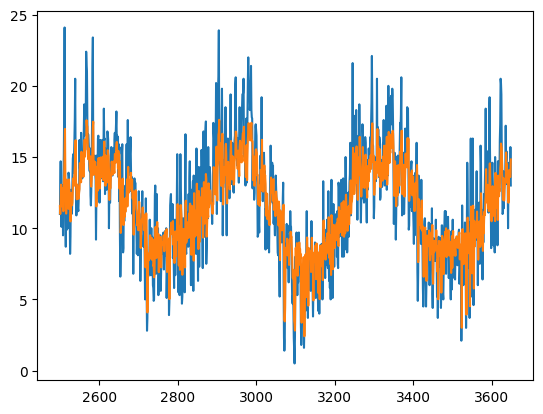

MAE: 1.8064829111099243
MSE: 5.3602705001831055


(1.8064829, 5.3602705)

In [21]:
test_ds = test_windowed_data(static.SERIES, static.WINDOW_SIZE, static.BATCH_SIZE, static.SHUFFLE_BUFFER_SIZE)
forecast = lstm_model.predict(test_ds)
lstm_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE: -1]
print(f"shape of forecast before {lstm_forecast.shape}")
lstm_forecast = lstm_forecast.squeeze()
print(f"shape of forecast after {lstm_forecast.shape}")

plt.plot(time_test, series_test)
plt.plot(time_test, lstm_forecast)
plt.show()

evaluate_model(series_test, lstm_forecast)

# Conv1D

In [39]:
conv_model = Sequential([
    Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[static.WINDOW_SIZE,1]),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(1)
])

conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 30, 64)            384       
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,545
Trainable params: 68,545
Non-trainable params: 0
_________________________________________________________________


In [27]:
lr_sc = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-6 * 10 ** (epoch/20))

In [29]:
sgd_opt = tf.keras.optimizers.SGD(learning_rate=static.LEARNING_RATE, momentum=0.9)
conv_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
                   optimizer=sgd_opt)
conv_history = conv_model.fit(train_ds, epochs=100, callbacks=[lr_sc])

Epoch 1/100
78/78 [==============================] - 11s 52ms/step - loss: 9.6301 - mae: 10.1285 - lr: 1.0000e-06
Epoch 2/100
78/78 [==============================] - 4s 46ms/step - loss: 9.6191 - mae: 10.1175 - lr: 1.1220e-06
Epoch 3/100
78/78 [==============================] - 3s 42ms/step - loss: 9.6066 - mae: 10.1049 - lr: 1.2589e-06
Epoch 4/100
78/78 [==============================] - 3s 42ms/step - loss: 9.5924 - mae: 10.0907 - lr: 1.4125e-06
Epoch 5/100
78/78 [==============================] - 4s 44ms/step - loss: 9.5764 - mae: 10.0747 - lr: 1.5849e-06
Epoch 6/100
78/78 [==============================] - 4s 53ms/step - loss: 9.5583 - mae: 10.0566 - lr: 1.7783e-06
Epoch 7/100
78/78 [==============================] - 3s 41ms/step - loss: 9.5376 - mae: 10.0359 - lr: 1.9953e-06
Epoch 8/100
78/78 [==============================] - 3s 41ms/step - loss: 9.5139 - mae: 10.0122 - lr: 2.2387e-06
Epoch 9/100
78/78 [==============================] - 4s 44ms/step - loss: 9.4860 - mae: 9.9844 

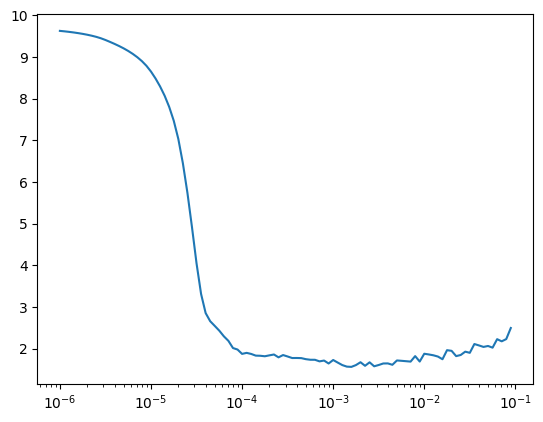

In [30]:
plt.semilogx(conv_history.history['lr'], conv_history.history['loss'])

In [40]:
sgd_opt = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
conv_model.compile(loss=tf.keras.losses.Huber(), metrics=["mae"],
                   optimizer=sgd_opt)
conv_history = conv_model.fit(train_ds, epochs=10)

Epoch 1/10
78/78 [==============================] - 8s 44ms/step - loss: 5.8023 - mae: 6.2841
Epoch 2/10
78/78 [==============================] - 4s 43ms/step - loss: 2.3127 - mae: 2.7727
Epoch 3/10
78/78 [==============================] - 5s 58ms/step - loss: 1.8560 - mae: 2.3063
Epoch 4/10
78/78 [==============================] - 3s 42ms/step - loss: 1.8071 - mae: 2.2571
Epoch 5/10
78/78 [==============================] - 4s 48ms/step - loss: 1.8216 - mae: 2.2721
Epoch 6/10
78/78 [==============================] - 3s 42ms/step - loss: 1.7304 - mae: 2.1817
Epoch 7/10
78/78 [==============================] - 3s 43ms/step - loss: 1.7221 - mae: 2.1759
Epoch 8/10
78/78 [==============================] - 4s 52ms/step - loss: 1.6632 - mae: 2.1104
Epoch 9/10
78/78 [==============================] - 3s 43ms/step - loss: 1.6897 - mae: 2.1358
Epoch 10/10
78/78 [==============================] - 3s 42ms/step - loss: 1.7353 - mae: 2.1872


114/114 [==============================] - 3s 22ms/step
shape of forecast before (1150, 1)
shape of forecast after (1150,)


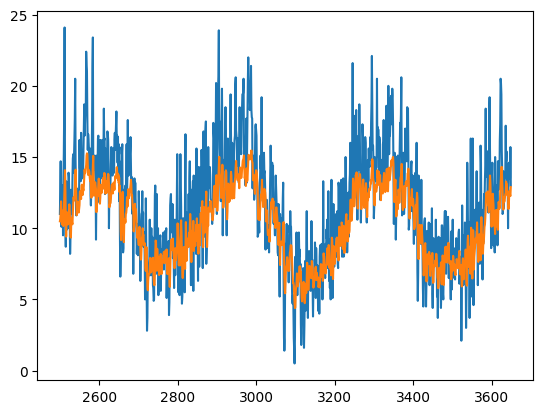

MAE: 2.192082405090332
MSE: 7.748871326446533


(2.1920824, 7.7488713)

In [41]:
test_ds = test_windowed_data(static.SERIES, static.WINDOW_SIZE, static.BATCH_SIZE, static.SHUFFLE_BUFFER_SIZE)
forecast = conv_model.predict(test_ds)
conv_forecast = forecast[static.TIME_SPLIT - static.WINDOW_SIZE: -1]
print(f"shape of forecast before {conv_forecast.shape}")
conv_forecast = conv_forecast.squeeze()
print(f"shape of forecast after {conv_forecast.shape}")

plt.plot(time_test, series_test)
plt.plot(time_test, conv_forecast)
plt.show()

evaluate_model(series_test, conv_forecast)